# Exploratory Data Analysis (Statistical Programing Exercise)

Your task is to perform an EDA process (Python) with this data to answer the following
questions:
#### 1. What percent of orders are under-authorized?

In [1]:
import pandas as pd

col_names= ["order_id", "activation_time_local", "country_code", "Store_address", "final_status", "payment_status", "products", "products_total", "purchase_total_price"]

df = pd.read_csv("fake_orders_test.csv", names=col_names)

#Checking types and nules/missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60400 entries, 0 to 60399
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id               60400 non-null  int64  
 1   activation_time_local  60400 non-null  object 
 2   country_code           60400 non-null  object 
 3   Store_address          60400 non-null  int64  
 4   final_status           60400 non-null  object 
 5   payment_status         60400 non-null  object 
 6   products               60400 non-null  int64  
 7   products_total         60400 non-null  float64
 8   purchase_total_price   60400 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 4.1+ MB


In [2]:
#A little brief of the main statistics
df.describe()

order_id  Store_address      products  products_total  \
count  6.040000e+04   60400.000000  60400.000000    60400.000000   
mean   3.278265e+07   41580.723692      2.811358        9.832693   
std    4.453627e+05   21905.784563      2.431214        9.276841   
min    3.150378e+07     190.000000      1.000000        0.000000   
25%    3.240091e+07   21110.000000      1.000000        4.110000   
50%    3.278110e+07   45849.000000      2.000000        7.120000   
75%    3.318279e+07   61992.250000      3.000000       12.750000   
max    3.356085e+07   75236.000000     39.000000      221.480000   

       purchase_total_price  
count          60400.000000  
mean              10.703447  
std               10.781632  
min                0.000000  
25%                4.330000  
50%                7.980000  
75%               14.160000  
max              265.760000

In [3]:
df = df[df["products_total"] > 0]
df.Store_address = df.Store_address.astype("str")

In [4]:
#Defining the function to give a value of "0" or "1" depending on the row value.
def under_authorized_func(row):
    if row['products_total'] * inc_auth < row['purchase_total_price']:
        val = 1
    else:
        val = 0
    return val

inc_auth = 1.00
df['under_authorized'] = df.apply(under_authorized_func, axis=1)
perc_under_authorized = df['under_authorized'].sum()/len(df)

print("The percentage of under-authorized orders is", "%.2f" % round(perc_under_authorized*100,2),"%" )

The percentage of under-authorized orders is 57.59 %


#### 2. What percent of orders would be correctly authorized w/ incremental authorisation (+20%) on the amount at checkout?

In [5]:
inc_auth = 1.20
df['new_under_authorized'] = df.apply(under_authorized_func, axis=1)
new_perc_under_authorized = df['new_under_authorized'].sum()/len(df)

print("The new percentage of under-authorized orders with an incremental authorization of 20% in the total price is", "%.2f" % round(new_perc_under_authorized*100,2),"%" )

The new percentage of under-authorized orders with an incremental authorization of 20% in the total price is 30.96 %


#### 3. Are there differences when split by country?


In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

df_groupedby_country = df[["country_code", "under_authorized", "new_under_authorized"]].groupby("country_code").agg(['sum', 'count'])
df_groupedby_country.columns = ['_'.join(str(i) for i in col) for col in df_groupedby_country.columns]
df_groupedby_country.reset_index(inplace=True)

df_groupedby_country["%under_authorized"] = df_groupedby_country["under_authorized_sum"]/df_groupedby_country["under_authorized_count"]
df_groupedby_country["%new_under_authorized"] = df_groupedby_country["new_under_authorized_sum"]/df_groupedby_country["new_under_authorized_count"]
df_groupedby_country = df_groupedby_country.sort_values("%under_authorized", ascending=False)
df_groupedby_country.reset_index(inplace=True)

In the next graph, we can realize that there can be a difference of almost 20% between the higher and the lower rate of under-authorized orders by country. Anyways, in the case of the countries with higher number of orders (ES-IT-TR) the % is between 50-60%.
We can also compare the new policy against the old one, so we can check in which countries the measure would be more effective (ES-PE-PR)

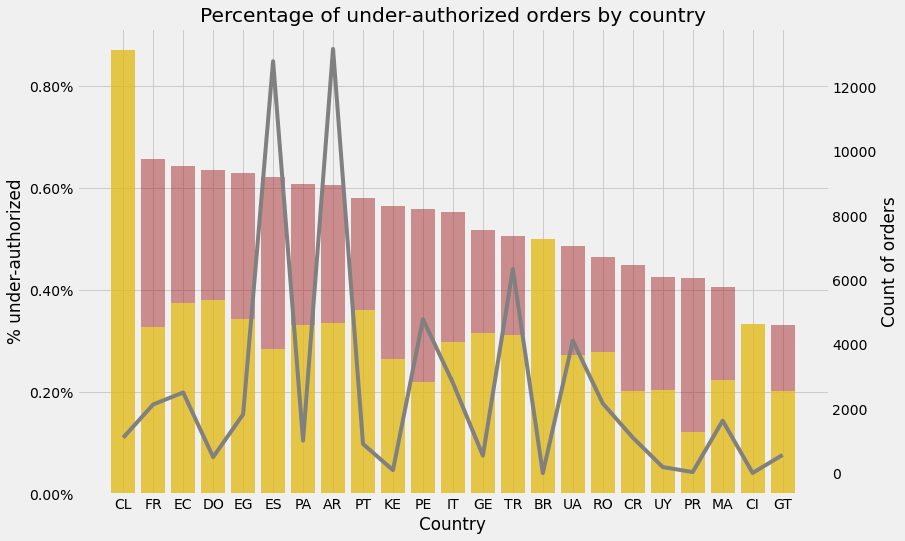

In [7]:
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

ax1.bar(df_groupedby_country['country_code'], df_groupedby_country['%under_authorized'], color="brown", alpha=0.5)
ax1.bar(df_groupedby_country['country_code'], df_groupedby_country['%new_under_authorized'], color="yellow", alpha=0.5)
ax1.set_title('Percentage of under-authorized orders by country')
ax1.set_xlabel('Country')
ax1.set_ylabel('% under-authorized')
fmt = '%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax1.yaxis.set_major_formatter(yticks)

ax2.plot(df_groupedby_country.new_under_authorized_count, color="gray")
ax2.grid(b=False)
ax2.set_ylabel('Count of orders')

plt.savefig("Orders_by_country")
plt.show()

#### 4. Which stores are the most problematic in terms of orders and monetary value?

In [8]:
#Grouping by stores
df_groupedby_store_under_auth = df[["Store_address", "under_authorized", "products_total"]].groupby(["Store_address"]).agg(['sum', 'count'])
df_groupedby_store_under_auth.columns = ['_'.join(str(i) for i in col) for col in df_groupedby_store_under_auth.columns]
df_groupedby_store_under_auth.reset_index(inplace=True)
df_groupedby_store_under_auth["%under_authorized"] = df_groupedby_store_under_auth["under_authorized_sum"]/df_groupedby_store_under_auth["under_authorized_count"]

#Using the mean of the % under_authorized, so we can focus in all the strores above the mean as really problematic.
df_groupedby_store_under_auth = df_groupedby_store_under_auth[df_groupedby_store_under_auth["%under_authorized"] > perc_under_authorized]

#I also use the mean of the count of orders and sum of the products_total, so we can take out the irrelevant stores in terms of quantity and amount of money.
df_groupedby_store_under_auth = df_groupedby_store_under_auth[df_groupedby_store_under_auth["products_total_count"] > df_groupedby_store_under_auth["products_total_count"].mean()]
df_groupedby_store_under_auth = df_groupedby_store_under_auth[df_groupedby_store_under_auth["products_total_sum"] > df_groupedby_store_under_auth["products_total_sum"].mean()]

df_groupedby_store_under_auth.drop(["under_authorized_sum", "under_authorized_count"], axis=1, inplace=True)

We can check the top 10 of stores with the higher amount of orders which are the most problematic by doing under-authorized orders.

In [9]:
df_count = df_groupedby_store_under_auth.sort_values("products_total_count", ascending=False).head(10).reset_index()
df_count

index Store_address  products_total_sum  products_total_count  \
0   1005         28671             4151.30                   492   
1    314         14455             2890.23                   252   
2   1011         28712             3544.20                   242   
3    992         28286             1187.90                   214   
4   1004         28669             5598.05                   201   
5    166         11694              801.32                   164   
6   1084         29451             2245.30                   152   
7   2081         47254             1699.27                   143   
8   3790         62935              957.74                   139   
9   5684          9089             2081.67                   134   

   %under_authorized  
0           0.910569  
1           0.710317  
2           0.896694  
3           0.953271  
4           0.786070  
5           0.975610  
6           0.664474  
7           0.706294  
8           0.798561  
9           0.626866

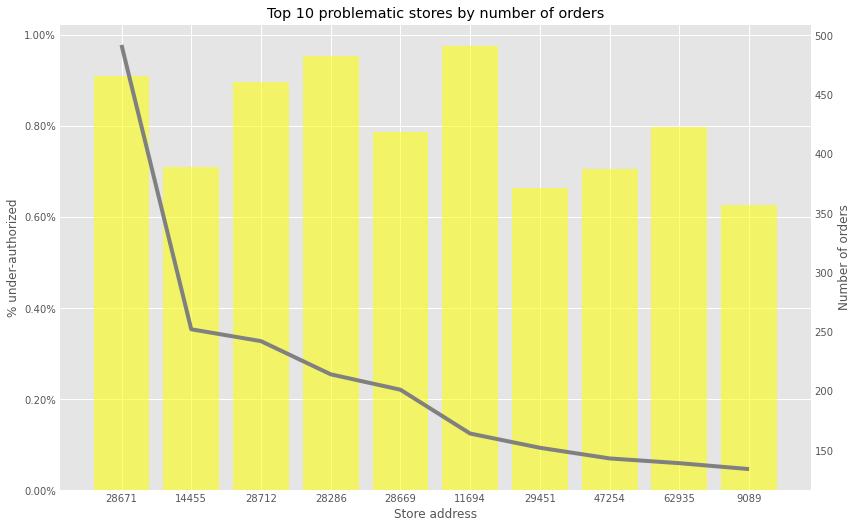

In [10]:
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

ax1.bar(df_count['Store_address'], df_count['%under_authorized'], color="yellow", alpha=0.55)
ax1.set_title('Top 10 problematic stores by number of orders')
ax1.set_xlabel('Store address')
ax1.set_ylabel('% under-authorized')
fmt = '%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax1.yaxis.set_major_formatter(yticks)

ax2.plot(df_count.products_total_count, color="gray")
ax2.grid(b=False)
ax2.set_ylabel('Number of orders')

plt.savefig("Top10stores_orders")
plt.show()

Same way, we can check the top 10 of stores with higher total value of orders which are the most problematic on doing under-authorized orders.

In [11]:
df_sum = df_groupedby_store_under_auth.sort_values("products_total_sum", ascending=False).head(10).reset_index()
df_sum

index Store_address  products_total_sum  products_total_count  \
0   1004         28669             5598.05                   201   
1   1005         28671             4151.30                   492   
2   1011         28712             3544.20                   242   
3    314         14455             2890.23                   252   
4   1084         29451             2245.30                   152   
5    957         27635             2122.70                   125   
6   5684          9089             2081.67                   134   
7   1675          4137             1870.50                    90   
8   1519         36504             1774.93                   125   
9    150         11361             1767.87                   120   

   %under_authorized  
0           0.786070  
1           0.910569  
2           0.896694  
3           0.710317  
4           0.664474  
5           0.928000  
6           0.626866  
7           0.911111  
8           0.840000  
9           0.775000

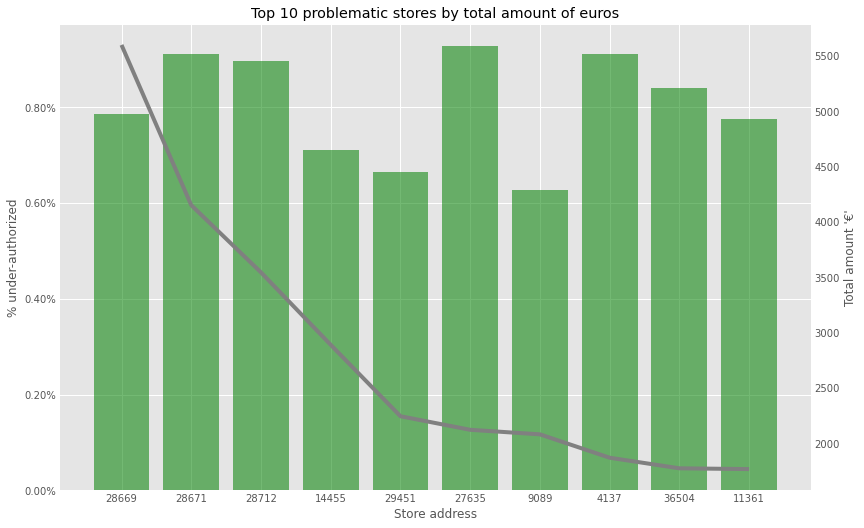

In [12]:
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

ax1.bar(df_sum['Store_address'], df_sum['%under_authorized'], color="green", alpha=0.55)
ax1.set_title('Top 10 problematic stores by total amount of euros')
ax1.set_xlabel('Store address')
ax1.set_ylabel('% under-authorized')
fmt = '%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax1.yaxis.set_major_formatter(yticks)

ax2.plot(df_sum.products_total_sum, color="gray")
ax2.grid(b=False)
ax2.set_ylabel("Total amount 'â‚¬'")

plt.savefig("Top10stores_monetary")
plt.show()

If it would be necessary, the dataframe could be converted into an Excel file so it could be sent to the right department to be checked and to take the correspondent actions.

In [13]:
df_excel = df_groupedby_store_under_auth.sort_values("products_total_count", ascending=False)
to_join = df[["country_code", 'Store_address']].drop_duplicates()
df_final = pd.merge(df_excel, to_join, how='left', on='Store_address')

df_final.to_excel(r'Problematic_stores.xlsx', index = False)